In [1]:
import pandas as pd 
import numpy as np 
import pickle 

from pathlib import Path 
from tqdm.notebook import tqdm_notebook

In [2]:
base = Path("data")

## embs: 
int2emb = pd.read_csv(Path("embeddings") / "GGVECEMB.csv", 
                      index_col=0)
int2emb = dict(zip(range(int2emb.shape[0]),
                   int2emb.to_numpy()))

## user seq: 
user_sequences = pd.read_csv(base / "FINAL_ALL_SEQUENCES_TRAINTEST.tsv", 
                             sep="\t")
user_sequences.SEQUENCE = user_sequences.SEQUENCE.apply(eval)

In [44]:
def seq2vec(seq, int2emb=int2emb):
    int2emb["PAD"] = np.nan
    def get_emb_from_graph(seq_v, int2emb=int2emb):
        if seq_v in int2emb:
            return int2emb[seq_v]
        else:
            return int2emb["PAD"]
    
    if len(seq) == 0:
        vec = np.nan
    elif len(seq) == 1: 
        
        vec = get_emb_from_graph(seq[0])
    else:
        vec = []
        for j in range(1, len(seq)-1):
            next_ = get_emb_from_graph(seq[j])
            prev_ = get_emb_from_graph(seq[j-1])
            try:
                if (not sum(pd.isna(next_)) ) and (not sum(pd.isna(prev_))):
                    vec.append(next_ - prev_)
            except:
                ...
        vec = np.array(vec)
        vec = vec.sum(axis=0)
            
    return vec 

In [4]:
## hash2int 
with open(base / "graph" / "hash2int.pic", "rb") as fp:
    hash2int = pickle.load(fp)


In [6]:
user_sequences.SEQUENCE = user_sequences.SEQUENCE.apply(lambda seq: [hash2int[s] for s in seq])

In [20]:
row

CLIENT_ID                                              1000100
SEQUENCE     [11979, 39, 34, 444063, 4403, 444064, 252, 209...
Name: 0, dtype: object

In [45]:
# res_human_emb = dict() 
for _, row in tqdm_notebook(user_sequences.iloc[_:].iterrows()): 
    client_id, seq = row["CLIENT_ID"], row["SEQUENCE"]
    res_human_emb[client_id] = seq2vec(seq)

0it [00:00, ?it/s]

In [66]:
list(res_human_emb.values())

[array([ 7.09529627e-01,  1.08951314e-01, -1.12585069e+00,  3.99182263e-01,
         6.67230583e-01,  9.36214208e-01, -3.78488036e-01, -2.20420986e-01,
         2.32322698e-01,  3.01078935e-01,  1.11120961e+00, -1.42966962e+00,
         8.89619691e-01, -3.78186406e-01,  2.37722385e-01, -1.06986227e+00,
         1.16000758e-01, -1.31229407e+00, -1.30479093e+00, -1.22529095e-02,
         1.39024105e+00, -5.06557857e-02,  3.84628527e-01,  6.56284220e-01,
        -4.30472076e-01,  6.83808606e-01,  4.87561636e-01,  7.46692434e-01,
        -1.86329412e-01,  3.92682285e-02, -1.44025923e-01, -9.97602891e-03,
        -9.73500000e+03]),
 array([ 7.95912633e-01,  7.23701549e-01,  8.52494924e-01, -5.36062387e-01,
        -4.40097451e-01,  1.00663512e+00, -1.36459907e+00,  3.72129650e-01,
         1.11692424e+00, -2.56590147e-01, -1.54709151e+00,  4.10609835e-01,
         1.48532793e+00,  7.55299617e-01,  1.38217139e-01, -1.19013037e+00,
        -4.92870072e-01, -5.74722780e-01, -6.97835257e-01, -1

In [80]:
for el in res_human_emb.values():
    print(len(el))
    break

33


In [93]:
X = pd.DataFrame.from_records(res_human_emb).T

X = X.reset_index(drop=False).rename({"index": "CLIENT_ID"}, axis=1)
X = X.rename(dict(zip(range(X.shape[1]), 
                      [f"x{j}" for j in range(X.shape[1])])),
             axis=1)


In [113]:
for col in X:
    X.loc[X[col].isna(), col] = X.loc[~X[col].isna(), col].mean()

In [116]:
X.to_csv("session_dataset.csv", index=False)

In [130]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X2d = tsne.fit_transform(X[[col for col in X if col != "CLIENT_ID"]])

KeyboardInterrupt: 

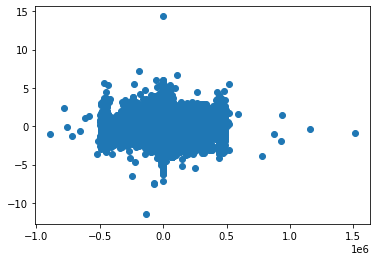

In [127]:
import matplotlib.pyplot as plt
plt.scatter(X2d[:,0], X2d[:,1])